### import

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
pwd

'/home/bianhaiyang/projects/cellgpt_v1/tmp_test/heca_experiments'

In [3]:
import torch
import os
from collections import Counter
import sklearn
import psutil
import numpy as np
import time
from loguru import logger

import pandas as pd
# import scanpy as sc
from tqdm import tqdm
import random
import sys
import multiprocessing
import anndata as ad
import gc
import pickle
# from torch.nn.utils.rnn import pad_sequence

root_path = os.path.abspath('/home/bianhaiyang/projects/cellgpt_v1/')
sys.path.append(os.path.abspath(root_path))

# from imp import reload
# reload(hf_tokenizer) # also reload(mymodule)

# from utils.hf_tokenizer import cellGenesisTokenizer

data_root_path = '/home/bianhaiyang/tmp_dataHub/datasets/'
dataset = 'ECA_GO'
dataPath = os.path.join(data_root_path,dataset)
assert os.path.exists(dataPath)
tmp_dataPath = os.path.join(dataPath,'tmp_files')

In [4]:
from utils.hf_tokenizer import cellGenesisTokenizer

In [5]:
from model.model import GPTConfig, cellGPTModel
import torch.nn.functional as F
from model import model_kvcache

In [6]:
cell_index_gene_mixed = torch.load(os.path.join(dataPath,'cell_index_gene_mixed.pt'))
cell_index_test = cell_index_gene_mixed['test_index_after_nonamp_mix']
cell_train_index_after_amp_mix = cell_index_gene_mixed['train_index_after_amp_mix']

In [7]:
meta_info = torch.load(os.path.join(dataPath,'meta_info.pt'))
chars = meta_info['token_set']
tokenizer = cellGenesisTokenizer(chars)

In [8]:
n_express_level = 10

In [9]:
meta_data = pd.read_csv(os.path.join(dataPath,'meta_data.csv'),index_col=0,low_memory=False)

### Init

In [11]:
import scanpy as sc
import matplotlib.pyplot as plt

In [12]:
def generate_prompt_for_cg(idx,meta_data,meta_pool):
    meta_num = torch.randint(0,len(meta_pool),(1,)).item()
    task_cols = meta_pool[meta_num]
    metadata_series = meta_data.loc[idx, task_cols]
    metadata_list = metadata_series.tolist()
    while 'Unclassified' in metadata_list:
        meta_num = torch.randint(0,len(meta_pool),(1,)).item()
        task_cols = meta_pool[meta_num]
        metadata_series = meta_data.loc[idx, task_cols]
        metadata_list = metadata_series.tolist()
    return metadata_list

In [13]:
def get_binned_expression(row):
    max_expr = row.max()
    bins = np.linspace(0, max_expr, 11) # 生成10个bin的边界，所以是11个值
    binned_expr = np.digitize(row, bins, right=True) # 减1是为了使得bin的范围在0-9之间
    return pd.Series(binned_expr/10, index=row.index)

In [14]:
def convert_cellsentence_ele_to_df(cellGene_ele, task = 'cs'):
    dfList = []
    ## fetch gene expression
    for c,e in tqdm(cellGene_ele):
        st = c.index(2207)+1
        c_list = tokenizer.convert_ids_to_tokens(c[st:-1])
        ele = e[st:-1]
        dfDict = {}
        for name,ele in zip(c_list,ele):
            dfDict[name] = ele/10
        dfList.append(dfDict)
    gDF = pd.DataFrame(dfList).fillna(0)
    return gDF

#### load model

In [40]:
from model.model import GPTConfig, cellGPTModel
import torch.nn.functional as F
from model.model_kvcache import cellGPTModel_kv

In [41]:
ckp = torch.load('/nfs/public/cell_gpt_data/dataHub/datasets/datasets/ECA_GO/model_hub/ckpt245000.pt')
gptconf = GPTConfig(**ckp['model_args'])
model_kv = cellGPTModel_kv(gptconf)
model_kv = model_kv.cuda()
model_kv.load_state_dict(ckp['model'])
model_kv.eval()

2023-11-04 00:07:37.109 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2023-11-04 00:07:44.037 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M


cellGPTModel_kv(
  (transformer): ModuleDict(
    (wte): Embedding(2222, 1120)
    (wee): Embedding(11, 1120)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-23): 24 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=1120, out_features=3360, bias=False)
          (c_proj): Linear(in_features=1120, out_features=1120, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=1120, out_features=4480, bias=False)
          (c_proj): Linear(in_features=4480, out_features=1120, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=1120, out_features=2222, bias=False)
  (epx_head): Linear(in_features=1120, out_features=2222, bias=False)
  (criterion): Masked

### All organs

In [164]:
cellDFHVG = pd.read_hdf(os.path.join(tmp_dataPath,'celldfhvg.h5'))
meta_data = pd.read_csv(os.path.join(dataPath,'meta_data.csv'),index_col=0,low_memory=False)

In [166]:
cellDF_test = cellDFHVG.loc[cell_index_test]

In [169]:
adata_test = sc.AnnData(cellDF_test)

In [171]:
adata_test.obs = meta_data.loc[cell_index_test]

In [172]:
adata_test.write('/nfs/public/cell_gpt_data/dataHub/datasets/datasets/ECA_GO/model_hub/eca_all_test.h5ad')

In [255]:
adata_test = sc.read_h5ad('/nfs/public/cell_gpt_data/dataHub/datasets/datasets/ECA_GO/model_hub/eca_all_test.h5ad')

In [215]:
del cellDF_test
del cellDFHVG

In [256]:
adata_organ = adata_test

In [174]:
adata_organ.X.max()

9.029805183410645

In [175]:
adata_organ.obs

study_id  donor_gender   
10X185_1:TGTTTGTCAGAAGTTA                 EGAS00001004107  Unclassified  \
10X353_4:TAAGCGTGTGCAACAG                      SCR_016152             M   
CATCAAGGTCGTCTTC GW22LPFCdeeper                 GSE132672  Unclassified   
BMP6-GGATGTTCATGCCTTC                Bone marrowblood_tmp  Unclassified   
ACCATTTTCCGGTTCT-328MCX                         GSE174332             M   
...                                                   ...           ...   
HSB231_1_DG_ATGCCTCCATTCAGGT                    GSE186538             F   
1838265lung_wfj                              Study23_lung             M   
ASGR1pos308_10_101                           Aizarani2019             F   
CB4_6-CCTTCCCTCAAGGTAA                     Bloodblood_tmp  Unclassified   
1696596-1lung_wfj                Unclassifiedlung_disease  Unclassified   

                                                            cell_type   
10X185_1:TGTTTGTCAGAAGTTA                                      Immune  \
10X353_4:TAAGCGTGTGCAACAG        Oligodendrocyte precursor cell (OPC)   
CATCAAGGTCGTCTTC GW22LPFCdeeper                       Epithelial cell   
BMP6-GGATGTTCATGCCTTC                                Naive CD8 T cell   
ACCATTTTCCGGTTCT-328MCX                                     Astrocyte   
...                                                               ...   
HSB231_1_DG_ATGCCTCCATTCAGGT                             Granule cell   
1838265lung_wfj                                      Naive CD4 T cell   
ASGR1pos308_10_101                                         Hepatocyte   
CB4_6-CCTTCCCTCAAGGTAA                               Naive CD8 T cell   
1696596-1lung_wfj                                       Memory B cell   

                                       organ       age_bin     donor_age   
10X185_1:TGTTTGTCAGAAGTTA              Brain       15 week           14w  \
10X353_4:TAAGCGTGTGCAACAG              Brain       30 year          29yr   
CATCAAGGTCGTCTTC GW22LPFCdeeper        Brain       20 week           22w   
BMP6-GGATGTTCATGCCTTC            Bone marrow  Unclassified  Unclassified   
ACCATTTTCCGGTTCT-328MCX                Brain  Unclassified  Unclassified   
...                                      ...           ...           ...   
HSB231_1_DG_ATGCCTCCATTCAGGT           Brain       80 year          79yr   
1838265lung_wfj                         Lung  Unclassified  Unclassified   
ASGR1pos308_10_101                     Liver       65 year          65yr   
CB4_6-CCTTCCCTCAAGGTAA                 Blood  Unclassified  Unclassified   
1696596-1lung_wfj                       Lung  Unclassified  Unclassified   

                                          region   seq_tech sample_status   
10X185_1:TGTTTGTCAGAAGTTA             Cerebellum        10X       Healthy  \
10X353_4:TAAGCGTGTGCAACAG               Amygdala        10X       Healthy   
CATCAAGGTCGTCTTC GW22LPFCdeeper  Cerebral cortex        10X       Healthy   
BMP6-GGATGTTCATGCCTTC                Bone marrow        10X       Healthy   
ACCATTTTCCGGTTCT-328MCX              Grey matter        10X       Healthy   
...                                          ...        ...           ...   
HSB231_1_DG_ATGCCTCCATTCAGGT         Hippocampus        10X       Healthy   
1838265lung_wfj                             Lung        10X       Healthy   
ASGR1pos308_10_101                         Liver  mCEL-Seq2       Healthy   
CB4_6-CCTTCCCTCAAGGTAA                Cord blood        10X       Healthy   
1696596-1lung_wfj                           PBMC        10X      COVID-19   

                                               MCT  
10X185_1:TGTTTGTCAGAAGTTA          Neuroglial cell  
10X353_4:TAAGCGTGTGCAACAG          Neuroglial cell  
CATCAAGGTCGTCTTC GW22LPFCdeeper               Cell  
BMP6-GGATGTTCATGCCTTC                   CD8 T cell  
ACCATTTTCCGGTTCT-328MCX            Neuroglial cell  
...                                            ...  
HSB231_1_DG_ATGCCTCCATTCAGGT     Excitatory neuron  
1838265lu

In [176]:
meta_sub = adata_organ.obs

In [98]:
adata_organ = adata_organ[:,meta_info['gene_set']]

In [177]:
adata_organ

AnnData object with n_obs × n_vars = 1309952 × 2000
    obs: 'study_id', 'donor_gender', 'cell_type', 'organ', 'age_bin', 'donor_age', 'region', 'seq_tech', 'sample_status', 'MCT'

In [100]:
# meta_sub = meta_sub[(meta_sub['study_id']=='10.1101/2021.07.30.454542') & (meta_sub['cell_type']!='Unclassified')]

In [101]:
pd.crosstab(meta_sub.age_bin,meta_sub.cell_type)

cell_type  Adipocyte  Adventitial fibroblast  B cell   
age_bin                                                
20 year            0                       0       0  \
35 year            0                       0       0   
40 year         1780                    1394       0   
45 year         1482                     936       0   
50 year         2495                    1051       0   
55 year          296                    1559       0   
60 year         5957                     963     211   
70 year          477                       0     320   

cell_type  Basement membrane fibroblast  Capillary endothelial cell   
age_bin                                                               
20 year                               0                         110  \
35 year                               0                         148   
40 year                           41596                       12000   
45 year                           19726                        3756   
50 year                           50267                       12415   
55 year                            9520                        2948   
60 year                           46900                       33143   
70 year                           16423                       34752   

cell_type  Cardiomyocyte cell  Cytotoxic CD8 T cell  Endothelial cell   
age_bin                                                                 
20 year                   333                     0               293  \
35 year                   697                     0               132   
40 year                 60003                     0                16   
45 year                 22945                     0               152   
50 year                131391                     0               130   
55 year                  6124                     0                 0   
60 year                 87734                   476                 0   
70 year                 28607                  1112                 0   

cell_type  Fibroblast  Lymphatic endothelial cell  ...  Monocyte   
age_bin                                            ...             
20 year            78                           2  ...         0  \
35 year            61                           0  ...         0   
40 year            86                         919  ...        79   
45 year           492                         297  ...       219   
50 year           203                         116  ...       295   
55 year             0                           0  ...       153   
60 year             0                         405  ...      5763   
70 year             0                         264  ...      3644   

cell_type  Myofibroblast  NK T cell  NK cell  Neuron   
age_bin                                                
20 year                0          0        0       0  \
35 year                0          0        0       0   
40 year              353        297        0    2056   
45 year                0          0      102       0   
50 year              145        723       82    2891   
55 year                0          0        0       0   
60 year             1812       1702     2846    1173   
70 year               63       1026     1528    1053   

cell_type  Neutrophilic granulocyte  Pericyte  Smooth muscle cell  T cell   
age_bin                                                                     
20 year                          29        69                  55      21  \
35 year                           7        27                  38      25   
40 year                           1     14138                6392     259   
45 year                         206      5009                1914      52   
50 year                          38     35530               10621    2417   
55 year                           0      3071                 107       0   
60 year                        1711     30001                5257     882   
70 year                         477     16799                4

In [102]:
meta_sub['donor_age']

AdultHeart_1.AAAACGAAAACGTAGAGA    52yr
AdultHeart_1.AAAACGTTCCGCCCATCT    52yr
AdultHeart_1.AAAGTTCACAAGTAGAGA    52yr
AdultHeart_1.AACCTAAGGACTGTCGGT    52yr
AdultHeart_1.AACCTAATACAGTGAAGC    52yr
                                   ... 
SC_97502_34_40                     36yr
SC_97502_32_60                     36yr
SC_97502_66_39                     36yr
SC_97502_30_13                     36yr
SC_97502_30_69                     36yr
Name: donor_age, Length: 908378, dtype: category
Categories (23, object): ['21yr', '33yr', '36yr', '39yr', ..., '60-65yr', '60yr', '65-70yr', '70-75yr']

In [103]:
meta_sub = meta_sub[((meta_sub['cell_type'] == 'Vascular endothelial cell'))\
& ((meta_sub['age_bin'] == '70 year') | (meta_sub['age_bin'] == '40 year'))]

In [104]:
meta_sub

cell_ID        donor_ID donor_gender   
M1.1.AAACGAAGTGGCGCTT_1  M1-1.AAACGAAGTGGCGCTT  Hua2020 Donor1            M  \
M1.1.AACAACCCACTAACCA_1  M1-1.AACAACCCACTAACCA  Hua2020 Donor1            M   
M1.1.AACCCAAAGGTGCCTC_1  M1-1.AACCCAAAGGTGCCTC  Hua2020 Donor1            M   
M1.1.AAGACAAGTCTACAAC_1  M1-1.AAGACAAGTCTACAAC  Hua2020 Donor1            M   
M1.1.AATGGAATCGATACGT_1  M1-1.AATGGAATCGATACGT  Hua2020 Donor1            M   
...                                        ...             ...          ...   
SC_96359_17_50                  SC_96359_17_50              N9            M   
SC_96359_49_54                  SC_96359_49_54              N9            M   
SC_96359_46_3                    SC_96359_46_3              N9            M   
SC_96359_51_35                  SC_96359_51_35              N9            M   
SC_96359_13_42                  SC_96359_13_42              N9            M   

                        donor_age original_name  organ     region   
M1.1.AAACGAAGTGGCGCTT_1      42yr            NA  Heart  Ventricle  \
M1.1.AACAACCCACTAACCA_1      42yr            NA  Heart  Ventricle   
M1.1.AACCCAAAGGTGCCTC_1      42yr            NA  Heart  Ventricle   
M1.1.AAGACAAGTCTACAAC_1      42yr            NA  Heart  Ventricle   
M1.1.AATGGAATCGATACGT_1      42yr            NA  Heart  Ventricle   
...                           ...           ...    ...        ...   
SC_96359_17_50               42yr            NA  Heart      Atria   
SC_96359_49_54               42yr            NA  Heart      Atria   
SC_96359_46_3                42yr            NA  Heart      Atria   
SC_96359_51_35               42yr            NA  Heart      Atria   
SC_96359_13_42               42yr            NA  Heart      Atria   

                              subregion sample_status   seq_tech   
M1.1.AAACGAAGTGGCGCTT_1  Left ventricle       Healthy        10X  \
M1.1.AACAACCCACTAACCA_1  Left ventricle       Healthy        10X   
M1.1.AACCCAAAGGTGCCTC_1  Left ventricle       Healthy        10X   
M1.1.AAGACAAGTCTACAAC_1  Left ventricle       Healthy        10X   
M1.1.AATGGAATCGATACGT_1  Left ventricle       Healthy        10X   
...                                 ...           ...        ...   
SC_96359_17_50               Left atria       Healthy  SMART-seq   
SC_96359_49_54               Left atria       Healthy  SMART-seq   
SC_96359_46_3                Left atria       Healthy  SMART-seq   
SC_96359_51_35               Left atria       Healthy  SMART-seq   
SC_96359_13_42               Left atria       Healthy  SMART-seq   

                                         cell_type if_patient donor_status   
M1.1.AAACGAAGTGGCGCTT_1  Vascular endothelial cell         No      Healthy  \
M1.1.AACAACCCACTAACCA_1  Vascular endothelial cell         No      Healthy   
M1.1.AACCCAAAGGTGCCTC_1  Vascular endothelial cell         No      Healthy   
M1.1.AAGACAAGTCTACAAC_1  Vascular endothelial cell         No      Healthy   
M1.1.AATGGAATCGATACGT_1  Vascular endothelial cell         No      Healthy   
...                                            ...        ...          ...   
SC_96359_17_50           Vascular endothelial cell         No      Healthy   
SC_96359_49_54           Vascular endothelial cell         No      Healthy   
SC_96359_46_3            Vascular endothelial cell         No      Healthy   
SC_96359_51_35           Vascular endothelial cell         No      Healthy   
SC_96359_13_42           Vascular endothelial cell         No      Healthy   

                        treatment ethnicity   
M1.1.AAACGAAGTGGCGCTT_1      None     Asian  \
M1.1.AACAACCCACTAACCA_1      None     Asian   
M1.1.AACCCAAAGGTGCCTC_1      None     Asian   
M1.1.AAGACAAGTCTACAAC_1      None     Asian   
M1.1.AATGGAATCGATACGT_1      None     Asian   
...                           ...       ...   
SC_96359_17_50               None     Asian   
SC_96359_49_54               None     Asian   
SC_96359_46_3                None     Asian   
SC_96359_51_35               None    

In [105]:
adata_organ = adata_organ[meta_sub.index]

In [106]:
# 这将为每个细胞计算非零元素的数量 (即有表达的基因的数量)
expressed_genes_per_cell = np.sum(adata_organ.X > 0, axis=1)

In [107]:
meta_idx_sample = random.sample(meta_sub.index.tolist(),k = 5000)

In [178]:
meta_sub

study_id  donor_gender   
10X185_1:TGTTTGTCAGAAGTTA                 EGAS00001004107  Unclassified  \
10X353_4:TAAGCGTGTGCAACAG                      SCR_016152             M   
CATCAAGGTCGTCTTC GW22LPFCdeeper                 GSE132672  Unclassified   
BMP6-GGATGTTCATGCCTTC                Bone marrowblood_tmp  Unclassified   
ACCATTTTCCGGTTCT-328MCX                         GSE174332             M   
...                                                   ...           ...   
HSB231_1_DG_ATGCCTCCATTCAGGT                    GSE186538             F   
1838265lung_wfj                              Study23_lung             M   
ASGR1pos308_10_101                           Aizarani2019             F   
CB4_6-CCTTCCCTCAAGGTAA                     Bloodblood_tmp  Unclassified   
1696596-1lung_wfj                Unclassifiedlung_disease  Unclassified   

                                                            cell_type   
10X185_1:TGTTTGTCAGAAGTTA                                      Immune  \
10X353_4:TAAGCGTGTGCAACAG        Oligodendrocyte precursor cell (OPC)   
CATCAAGGTCGTCTTC GW22LPFCdeeper                       Epithelial cell   
BMP6-GGATGTTCATGCCTTC                                Naive CD8 T cell   
ACCATTTTCCGGTTCT-328MCX                                     Astrocyte   
...                                                               ...   
HSB231_1_DG_ATGCCTCCATTCAGGT                             Granule cell   
1838265lung_wfj                                      Naive CD4 T cell   
ASGR1pos308_10_101                                         Hepatocyte   
CB4_6-CCTTCCCTCAAGGTAA                               Naive CD8 T cell   
1696596-1lung_wfj                                       Memory B cell   

                                       organ       age_bin     donor_age   
10X185_1:TGTTTGTCAGAAGTTA              Brain       15 week           14w  \
10X353_4:TAAGCGTGTGCAACAG              Brain       30 year          29yr   
CATCAAGGTCGTCTTC GW22LPFCdeeper        Brain       20 week           22w   
BMP6-GGATGTTCATGCCTTC            Bone marrow  Unclassified  Unclassified   
ACCATTTTCCGGTTCT-328MCX                Brain  Unclassified  Unclassified   
...                                      ...           ...           ...   
HSB231_1_DG_ATGCCTCCATTCAGGT           Brain       80 year          79yr   
1838265lung_wfj                         Lung  Unclassified  Unclassified   
ASGR1pos308_10_101                     Liver       65 year          65yr   
CB4_6-CCTTCCCTCAAGGTAA                 Blood  Unclassified  Unclassified   
1696596-1lung_wfj                       Lung  Unclassified  Unclassified   

                                          region   seq_tech sample_status   
10X185_1:TGTTTGTCAGAAGTTA             Cerebellum        10X       Healthy  \
10X353_4:TAAGCGTGTGCAACAG               Amygdala        10X       Healthy   
CATCAAGGTCGTCTTC GW22LPFCdeeper  Cerebral cortex        10X       Healthy   
BMP6-GGATGTTCATGCCTTC                Bone marrow        10X       Healthy   
ACCATTTTCCGGTTCT-328MCX              Grey matter        10X       Healthy   
...                                          ...        ...           ...   
HSB231_1_DG_ATGCCTCCATTCAGGT         Hippocampus        10X       Healthy   
1838265lung_wfj                             Lung        10X       Healthy   
ASGR1pos308_10_101                         Liver  mCEL-Seq2       Healthy   
CB4_6-CCTTCCCTCAAGGTAA                Cord blood        10X       Healthy   
1696596-1lung_wfj                           PBMC        10X      COVID-19   

                                               MCT  
10X185_1:TGTTTGTCAGAAGTTA          Neuroglial cell  
10X353_4:TAAGCGTGTGCAACAG          Neuroglial cell  
CATCAAGGTCGTCTTC GW22LPFCdeeper               Cell  
BMP6-GGATGTTCATGCCTTC                   CD8 T cell  
ACCATTTTCCGGTTCT-328MCX            Neuroglial cell  
...                                            ...  
HSB231_1_DG_ATGCCTCCATTCAGGT     Excitatory neuron  
1838265lu

In [188]:
meta_sub_sub.organ.value_counts()

organ
Brain          746230
Lung           249544
Blood          103357
Heart           90810
Liver           60299
Bone marrow     58316
Thymus              0
Name: count, dtype: int64

In [189]:
non_zero_organs = meta_sub_sub['organ'].value_counts()
non_zero_organs = non_zero_organs[non_zero_organs > 0].index
# 然后只保留这些类别的行
meta_sub_sub = meta_sub_sub[meta_sub_sub['organ'].isin(non_zero_organs)]

In [195]:
meta_sub_sub = meta_sub[(meta_sub.organ == 'Brain')|(meta_sub.organ == 'Lung')|(meta_sub.organ == 'Blood')|(meta_sub.organ == 'Heart')\
|(meta_sub.organ == 'Liver')|(meta_sub.organ == 'Bone marrow')].copy()

meta_sub_sub.organ.value_counts().list()

organ
Brain          746230
Lung           249544
Blood          103357
Heart           90810
Liver           60299
Bone marrow     58316
Thymus              0
Name: count, dtype: int64

In [203]:
sample_organ_index = []
for org in meta_sub_sub.organ.value_counts().keys().tolist()[:-1]:
    sample_organ_index.extend(random.sample(meta_sub_sub[meta_sub_sub.organ == org].index.tolist(), 3000))

In [206]:
meta_idx_sample = sample_organ_index

In [213]:
# 这将为每个细胞计算非零元素的数量 (即有表达的基因的数量)
expressed_genes_per_cell = np.sum(adata_organ.X > 0, axis=1)

In [216]:
len(expressed_genes_per_cell)

18000

In [225]:
np.array(expressed_genes_per_cell[:10])

array([456, 107,  64, 364, 214, 443,  63,  86, 201, 560])

(array([4., 0., 1., 1., 0., 0., 1., 2., 0., 1.]),
 array([ 63. , 112.7, 162.4, 212.1, 261.8, 311.5, 361.2, 410.9, 460.6,
        510.3, 560. ]),
 <BarContainer object of 10 artists>)

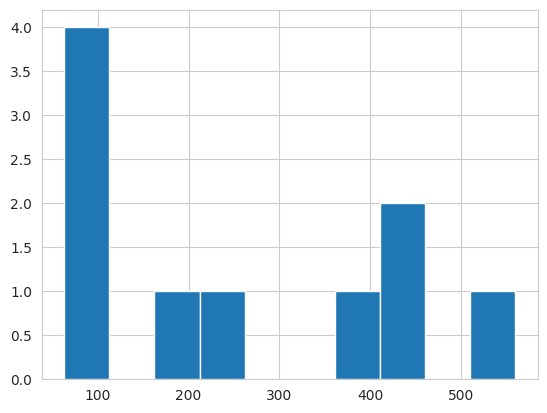

In [226]:
plt.hist(np.array(expressed_genes_per_cell[:10]))

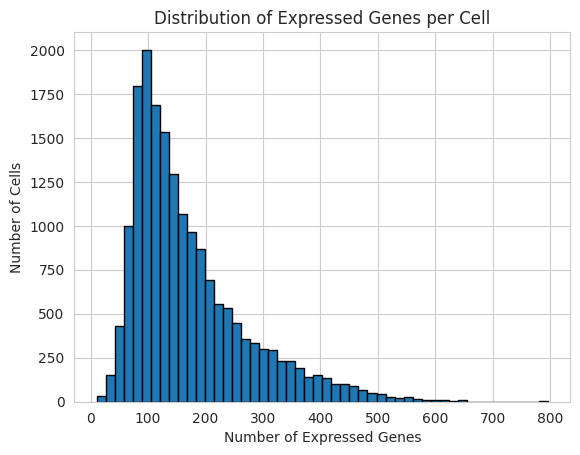

In [228]:
plt.hist(np.array(expressed_genes_per_cell), bins=50, edgecolor="k")
plt.xlabel("Number of Expressed Genes")
plt.ylabel("Number of Cells")
plt.title("Distribution of Expressed Genes per Cell")
plt.show()

In [257]:
adata_organ = adata_test[meta_idx_sample,:]

In [207]:
# adata_organ = adata_organ[meta_idx_sample,:]

In [208]:
meta_sub = meta_sub.loc[meta_idx_sample]

In [239]:
idx = meta_idx_sample[2338]

In [240]:
meta_pool = [['organ','cell_type']]

In [241]:
prompt_condition = generate_prompt_for_cg(idx,meta_sub,meta_pool) + ['<SPToken1>']
print(prompt_condition)
prompts_id = tokenizer.convert_tokens_to_ids(prompt_condition)
prompt = torch.tensor(prompts_id).unsqueeze(0).cuda()
prompt_ele = torch.zeros(prompt.shape,dtype=torch.int64).cuda()
with torch.no_grad():
    generated = model_kv.generate_cellGenesis(prompt, prompt_ele, max_new_tokens=1000, top_k=200, gamma=0.2)
generated_genes = generated[0].cpu().tolist()[0]
print(len(generated_genes))

['Brain', 'Neuron', '<SPToken1>']
165


In [116]:
meta_info['gene_set']

['A2M',
 'ABCA1',
 'ABCA6',
 'ABCA8',
 'ABCA9',
 'ABCB1',
 'ABCC4',
 'ABCC9',
 'ABCG2',
 'ABI3BP',
 'ABTB2',
 'ACAP1',
 'ACKR1',
 'ACKR3',
 'ACP5',
 'ACSL1',
 'ACSM3',
 'ACTA2',
 'ACTC1',
 'ACTG2',
 'ACVRL1',
 'ACY3',
 'ADAM12',
 'ADAM19',
 'ADAM28',
 'ADAMTS1',
 'ADAMTS12',
 'ADAMTS17',
 'ADAMTS18',
 'ADAMTS4',
 'ADAMTS5',
 'ADAMTS6',
 'ADAMTS9',
 'ADAMTS9-AS2',
 'ADAMTSL1',
 'ADAMTSL2',
 'ADAMTSL3',
 'ADAP2',
 'ADARB2',
 'ADCY4',
 'ADCYAP1',
 'ADGRE2',
 'ADGRF5',
 'ADGRG1',
 'ADGRG3',
 'ADGRG6',
 'ADGRL2',
 'ADGRL4',
 'ADGRV1',
 'ADH1B',
 'ADIRF',
 'ADM',
 'ADRB2',
 'AEBP1',
 'AFF3',
 'AGMO',
 'AGR2',
 'AGT',
 'AHNAK',
 'AHSP',
 'AIF1',
 'AIF1L',
 'AKAP12',
 'AKR1C1',
 'ALAS2',
 'ALDH1A1',
 'ALDH1A2',
 'ALDH1L1',
 'ALDOB',
 'ALOX5',
 'ALOX5AP',
 'ALPL',
 'ANGPT1',
 'ANGPT2',
 'ANGPTL4',
 'ANK3',
 'ANKRD1',
 'ANKRD22',
 'ANKRD37',
 'ANKRD44',
 'ANKRD55',
 'ANLN',
 'ANO2',
 'ANPEP',
 'ANXA1',
 'ANXA2',
 'ANXA2R',
 'ANXA3',
 'ANXA4',
 'AOAH',
 'AOX1',
 'APBA2',
 'APBB1IP',
 'APCDD1',
 '

In [86]:
from imp import reload

/tmp/ipykernel_786299/4113565812.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [87]:
reload(get_cell)

<module 'tmp_test.heca_experiments.get_cell' from '/home/bianhaiyang/projects/cellgpt_v1/tmp_test/heca_experiments/get_cell.py'>

#### parallel generation

In [243]:
from multiprocessing import Pool
import multiprocessing
from tmp_test.heca_experiments import get_cell

def pack_arg(arg,n_process):
    return [arg for _ in range(n_process)]

if __name__ == '__main__': 
    multiprocessing.set_start_method('spawn', force=True)
    print('当前母进程: {}'.format(os.getpid()))
    start = time.time()
    # world_size = torch.cuda.device_count()
    # 使用的gpu设备，卡2，卡3
    gamma = 0.2
    use_gpu_device = [0,1,2,3]
    n_process_in_each_gpu = 2
    world_size = len(use_gpu_device)
    n_process = n_process_in_each_gpu * world_size
    process_idx = list(range(n_process))
    devices = [device for device in use_gpu_device for _ in range(n_process_in_each_gpu)]    

    print("devices: ",devices)
    ckp_path = '/nfs/public/cell_gpt_data/dataHub/datasets/datasets/ECA_GO/model_hub/ckpt245000.pt'
    results_dir = 'generated_eca_all/'
    if not os.path.exists(results_dir):
        os.mkdir(results_dir)
    results_save_dir = results_dir + 'eca_generate_02gamma_'
    meta_data_organ = meta_sub


    idxs = np.array_split(meta_data_organ.index, n_process)
    idxs = [list(idx) for idx in idxs]
    gammas = pack_arg(gamma,n_process)
    # uHAF_paths = pack_arg(uHAF_path,n_process)
    # data_organ_paths = pack_arg(data_organ_path,n_process)
    meta_organs = pack_arg(meta_data_organ,n_process)
    ckp_paths = pack_arg(ckp_path,n_process)
    results_save_dirs = [results_save_dir+str(process_id)+'results.pt' for _,process_id in zip(devices,process_idx)]
    
    args = [(idx, device,gamma, meta_organ,ckp_path,save_path) \
            for idx, device, gamma, meta_organ,ckp_path,save_path in \
            zip(idxs, devices,gammas, meta_organs, ckp_paths,results_save_dirs)]

    # 创建进程池
    with Pool(n_process) as pool:
        # 使用pool.map并行处理
        pool.map(get_cell.generate, args)
            
    end = time.time()
    print("总共用时{}秒".format((end - start)))

当前母进程: 116064
devices:  [0, 0, 1, 1, 2, 2, 3, 3]


2023-11-04 10:41:10.957 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2023-11-04 10:41:10.982 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2023-11-04 10:41:10.988 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2023-11-04 10:41:10.988 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2023-11-04 10:41:10.989 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2023-11-04 10:41:10.989 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2023-11-04 10:41:10.990 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2023-11-04 10:41:11.020 | INFO     | model.model_kvcache:__init__:252 - Current ele mode is: 1
2023-11-04 10:41:17.552 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M
2023-11-04 10:41:17.569 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M
2023-11-04 10:41:17.725 | INFO     |

当前子进程: 1494476
当前子进程: 1494449


  0%|          | 0/2250 [00:00<?, ?it/s]2023-11-04 10:41:17.869 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M


当前子进程: 1494474
当前子进程: 1494470


  0%|          | 0/2250 [00:00<?, ?it/s]2023-11-04 10:41:18.179 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M
2023-11-04 10:41:18.217 | INFO     | model.model_kvcache:__init__:291 - number of parameters: 368.80M
  0%|          | 0/2250 [00:00<?, ?it/s]

当前子进程: 1494438
当前子进程: 1494175
当前子进程: 1494472


  0%|          | 0/2250 [00:00<?, ?it/s] 1.65s/it]

当前子进程: 1494485


100%|██████████| 2250/2250 [1:02:47<00:00,  1.67s/it]


总共用时3823.4751358032227秒


In [49]:
results_root = './generated_heart_two/'
results_save_dirs = [results_root+res_p for res_p in os.listdir(results_root) if 'generate' in res_p]

In [50]:
results_save_dirs.sort()

In [51]:
results_save_dirs

['./generated_heart_two/heart_generate_02gamma_0results.pt',
 './generated_heart_two/heart_generate_02gamma_1results.pt',
 './generated_heart_two/heart_generate_02gamma_2results.pt',
 './generated_heart_two/heart_generate_02gamma_3results.pt',
 './generated_heart_two/heart_generate_02gamma_4results.pt',
 './generated_heart_two/heart_generate_02gamma_5results.pt',
 './generated_heart_two/heart_generate_02gamma_6results.pt',
 './generated_heart_two/heart_generate_02gamma_7results.pt']

In [52]:
all_results = {'idx': [], 'cgg': [], 'cge': []}

for path in tqdm(results_save_dirs):
    # 加载结果
    results = torch.load(path)

    # 将每个结果文件的内容添加到all_results字典
    for key, value in results.items():
        all_results[key].extend(value)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 53.37it/s]


#### load original data

In [261]:
adata_real_ = adata_organ

In [262]:
celldataA = adata_real_.X.toarray()
cellDFHVG = pd.DataFrame(celldataA, columns = meta_info['gene_set'])
cellDFHVG.index = adata_real_.obs.index.tolist()

In [263]:
meta_adata = adata_real_.obs

In [264]:
celldata_bin = cellDFHVG.apply(get_binned_expression, axis=1)

In [265]:
celldata_bin

A2M  ABCA1  ABCA6  ABCA8  ABCA9  ABCB1  ABCC4   
10X215_3:GTTACCCCAAACACCT     0.0    0.0    0.1    0.0    0.1    0.1    0.0  \
10X125_1:GCTGCGACAGCCTGTG     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
ACGCCGACACGTCAGC-GW18_02_CGE  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
TCCCACAGTTTGACAC_9-1          0.0    0.0    0.0    0.0    0.0    0.0    0.0   
10X196_1:TCATTTGCATGAAGCG     0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...                           ...    ...    ...    ...    ...    ...    ...   
BMP6-ACTGCTCTCACGAAGG         0.0    0.0    0.0    0.0    0.0    0.0    0.0   
BMP2-TCAGCTCCAACACCCG         0.0    0.0    0.0    0.0    0.0    0.0    0.0   
GCATACACACGCCAGT_elderly2     0.0    0.0    0.0    0.0    0.0    0.0    0.2   
GTTCTCGCATCCCATC_elderly1     0.0    0.0    0.0    0.0    0.0    0.3    0.2   
ACTTACTTCAGTACGT_young4       0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                              ABCC9  ABCG2  ABI3BP  ...  ZNF366  ZNF385B   
10X215_3:GTTACCCCAAACACCT       0.0    0.0     0.1  ...     0.0      0.4  \
10X125_1:GCTGCGACAGCCTGTG       0.0    0.0     0.0  ...     0.0      0.0   
ACGCCGACACGTCAGC-GW18_02_CGE    0.0    0.0     0.0  ...     0.0      0.0   
TCCCACAGTTTGACAC_9-1            0.0    0.0     0.2  ...     0.0      0.0   
10X196_1:TCATTTGCATGAAGCG       0.0    0.0     0.0  ...     0.0      0.0   
...                             ...    ...     ...  ...     ...      ...   
BMP6-ACTGCTCTCACGAAGG           0.0    0.0     0.0  ...     0.0      0.0   
BMP2-TCAGCTCCAACACCCG           0.0    0.0     0.0  ...     0.0      0.0   
GCATACACACGCCAGT_elderly2       0.0    0.0     0.0  ...     0.0      0.0   
GTTCTCGCATCCCATC_elderly1       0.0    0.0     0.0  ...     0.0      0.0   
ACTTACTTCAGTACGT_young4         0.0    0.0     0.0  ...     0.0      0.0   

                              ZNF385D  ZNF521  ZNF536  ZNF683  ZNF80  ZNF804A   
10X215_3:GTTACCCCAAACACCT         0.1     0.2     0.0     0.0    0.0      0.3  \
10X125_1:GCTGCGACAGCCTGTG         0.0     0.3     0.0     0.0    0.0      0.0   
ACGCCGACACGTCAGC-GW18_02_CGE      0.0     0.0     0.3     0.0    0.0      0.0   
TCCCACAGTTTGACAC_9-1              0.0     0.0     0.0     0.0    0.0      0.0   
10X196_1:TCATTTGCATGAAGCG         0.0     0.2     0.0     0.0    0.0      0.0   
...                               ...     ...     ...     ...    ...      ...   
BMP6-ACTGCTCTCACGAAGG             0.0     0.0     0.0     0.0    0.0      0.0   
BMP2-TCAGCTCCAACACCCG             0.0     0.0     0.0     0.0    0.0      0.0   
GCATACACACGCCAGT_elderly2         0.0     0.0     0.0     0.0    0.0      0.0   
GTTCTCGCATCCCATC_elderly1         0.0     0.0     0.0     0.0    0.0      0.0   
ACTTACTTCAGTACGT_young4           0.0     0.0     0.0     0.0    0.0      0.0   

                              ZNF804B  ZNF831  
10X215_3:GTTACCCCAAACACCT         0.0     0.0  
10X125_1:GCTGCGACAGCCTGTG         0.0     0.0  
ACGCCGACACGTCAGC-GW18_02_CGE      0.0     0.0  
TCCCACAGTTTGACAC_9-1              0.0     0.0  
10X196_1:TCATTTGCATGAAGCG         0.0     0.0  
...                               ...     ...  
BMP6-ACTGCTCTCACGAAGG             0.0     0.0  
BMP2-TCAGCTCCAACACCCG             0.0     0.0  
GCATACACACGCCAGT_elderly2         0.0     0.0  
GTTCTCGCATCCCATC_elderly1         0.0     0.0  
ACTTACTTCAGTACGT_young4           0.0     0.0  

[18000 rows x 2000 columns]

In [304]:
adata_real = sc.AnnData(celldata_bin.astype(float))
adata_real.obs['cell_type'] = meta_adata.cell_type
adata_real.obs['seq_tech'] = meta_adata.seq_tech
adata_real.obs['age_bin'] = meta_adata.age_bin
adata_real.obs['donor_gender'] = meta_adata.donor_gender
adata_real.obs['organ'] = meta_adata.organ

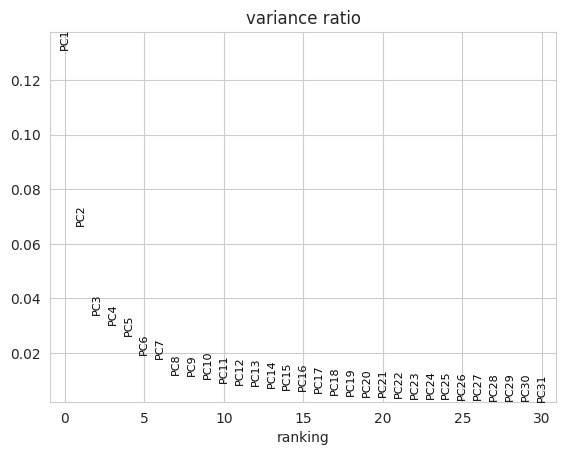

In [305]:
sc.pp.pca(adata_real)
sc.pl.pca_variance_ratio(adata_real)

In [306]:
sc.pp.neighbors(adata_real,n_pcs=10)
sc.tl.umap(adata_real)

/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


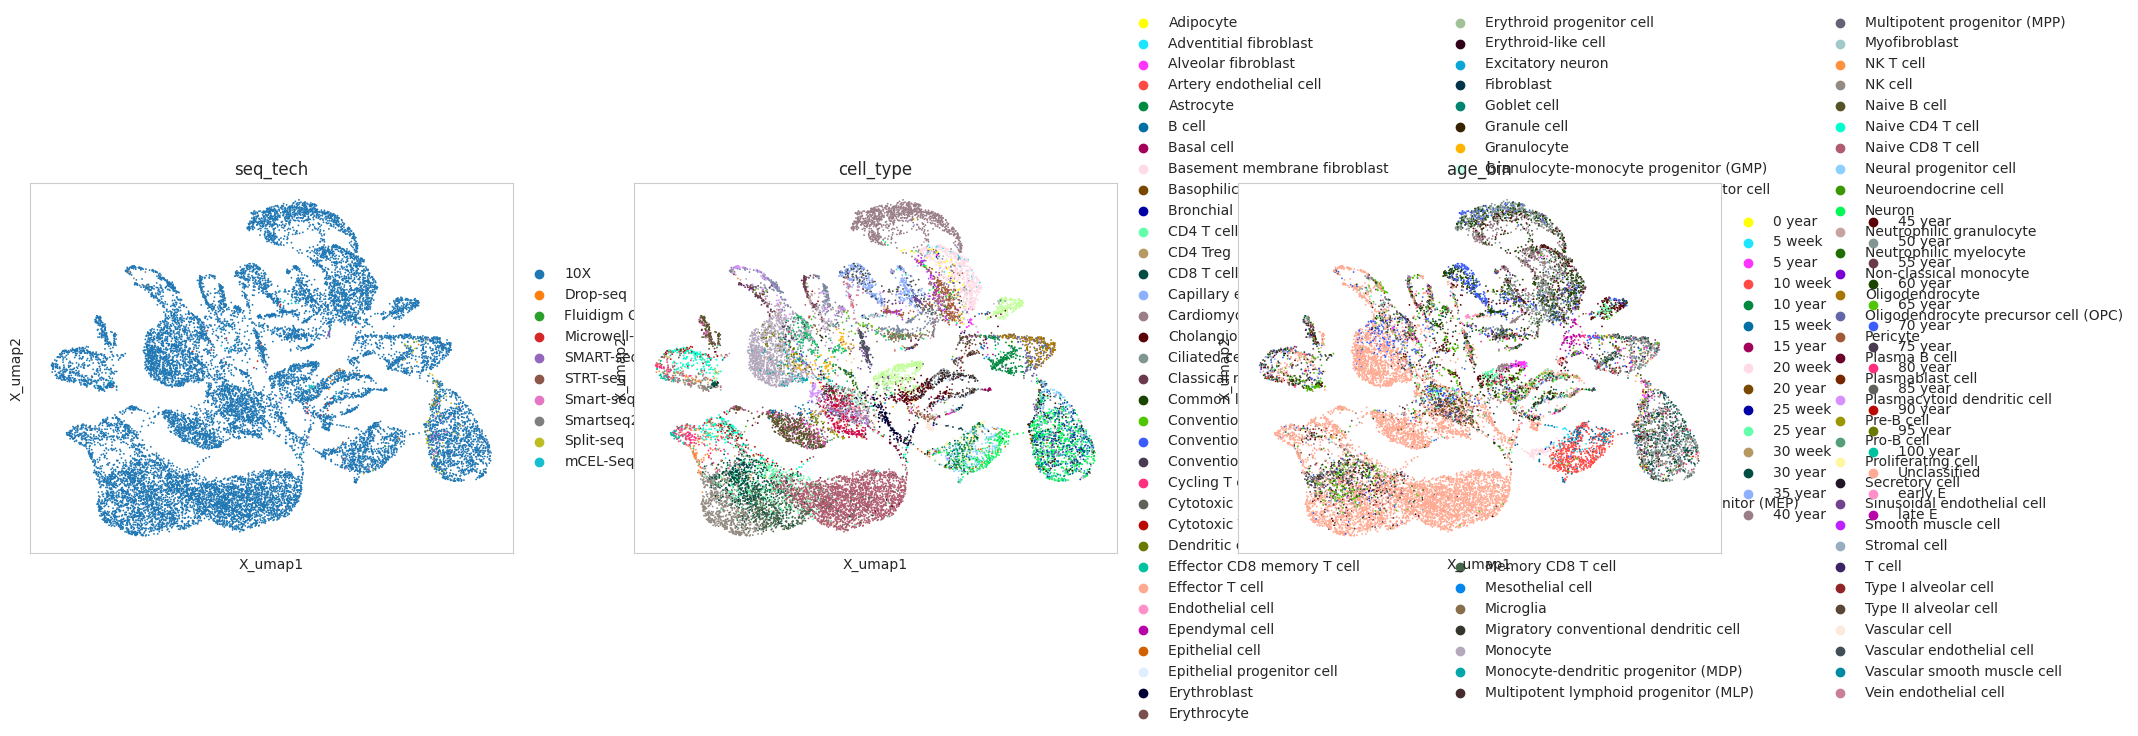

In [307]:
sc.pl.embedding(adata_real, basis='X_umap',color=['seq_tech','cell_type','age_bin'])

#### load generated data

In [270]:
results_root = './generated_eca_all/'
results_save_dirs = [results_root+res_p for res_p in os.listdir(results_root) if '02gamma' in res_p]

In [271]:
results_save_dirs.sort()

In [272]:
results_save_dirs

['./generated_eca_all/eca_generate_02gamma_0results.pt',
 './generated_eca_all/eca_generate_02gamma_1results.pt',
 './generated_eca_all/eca_generate_02gamma_2results.pt',
 './generated_eca_all/eca_generate_02gamma_3results.pt',
 './generated_eca_all/eca_generate_02gamma_4results.pt',
 './generated_eca_all/eca_generate_02gamma_5results.pt',
 './generated_eca_all/eca_generate_02gamma_6results.pt',
 './generated_eca_all/eca_generate_02gamma_7results.pt']

In [273]:
all_results = {'idx': [], 'cgg': [], 'cge': []}

for path in tqdm(results_save_dirs):
    # 加载结果
    results = torch.load(path)

    # 将每个结果文件的内容添加到all_results字典
    for key, value in results.items():
        all_results[key].extend(value)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 20.46it/s]


In [274]:
cgg = all_results['cgg']
cge = all_results['cge']

In [275]:
gg_len = []
for gg in cgg:
    gg_len.append(len(gg))

(array([8.400e+01, 6.600e+02, 2.302e+03, 3.884e+03, 3.779e+03, 2.465e+03,
        1.493e+03, 9.970e+02, 6.830e+02, 4.440e+02, 2.930e+02, 2.020e+02,
        1.350e+02, 1.040e+02, 6.600e+01, 8.000e+01, 6.100e+01, 4.500e+01,
        4.400e+01, 2.900e+01, 3.000e+01, 2.400e+01, 1.700e+01, 1.700e+01,
        9.000e+00, 1.000e+01, 1.300e+01, 6.000e+00, 7.000e+00, 4.000e+00,
        4.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.011  , 0.01943, 0.02786, 0.03629, 0.04472, 0.05315, 0.06158,
        0.07001, 0.07844, 0.08687, 0.0953 , 0.10373, 0.11216, 0.12059,
        0.12902, 0.13745, 0.14588, 0.15431, 0.16274, 0.17117, 0.1796 ,
        0.18803, 0.19646, 0.20489, 0.21332, 0.22175, 0.23018, 0.23861,
        0.24704, 0.25547, 0.2639 , 0.27233, 0.28076, 0.28919, 0.29762,
        0.30605, 0.31

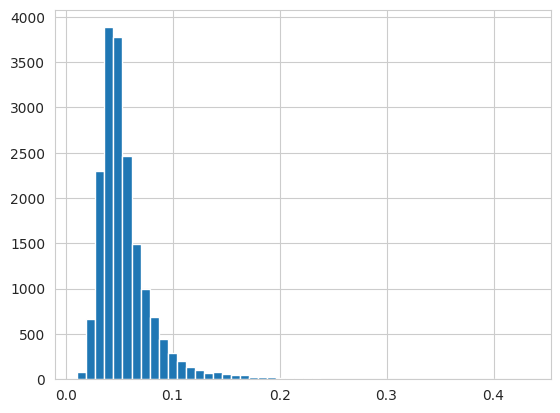

In [276]:
plt.hist(np.array(gg_len)/2000,bins=50)

In [277]:
gDF = convert_cellsentence_ele_to_df(zip(cgg,cge))

18000it [00:00, 22434.93it/s]


In [278]:
gDF

PLCL1  HECW2  PCDH9  GPM6A  MT-CYB  HSP90AA1  AUTS2  MT-CO2  MARCKSL1   
0        0.3    0.3    0.6    0.4     0.4       0.4    0.5     0.5       0.6  \
1        0.0    0.0    0.0    0.3     0.5       0.5    0.3     0.6       0.5   
2        0.0    0.3    0.0    0.4     0.5       0.4    0.4     0.6       0.5   
3        0.0    0.0    0.0    0.0     0.7       0.5    0.0     0.8       0.0   
4        0.0    0.0    0.4    0.4     0.5       0.4    0.4     0.6       0.0   
...      ...    ...    ...    ...     ...       ...    ...     ...       ...   
17995    0.0    0.0    0.0    0.0     0.5       0.0    0.0     0.5       0.4   
17996    0.0    0.0    0.0    0.0     0.5       0.0    0.0     0.7       0.0   
17997    0.0    0.0    0.0    0.0     0.6       0.4    0.3     0.7       0.3   
17998    0.0    0.0    0.0    0.0     0.7       0.4    0.0     0.7       0.4   
17999    0.0    0.0    0.0    0.0     0.6       0.5    0.0     0.6       0.4   

       PDE10A  ...  MRO  C2CD4B  PRTN3  MS4A3  DEFA4  BPI  PGLYRP1  KIR2DL3   
0         0.3  ...  0.0     0.0    0.0    0.0    0.0  0.0      0.0      0.0  \
1         0.0  ...  0.0     0.0    0.0    0.0    0.0  0.0      0.0      0.0   
2         0.3  ...  0.0     0.0    0.0    0.0    0.0  0.0      0.0      0.0   
3         0.0  ...  0.0     0.0    0.0    0.0    0.0  0.0      0.0      0.0   
4         0.0  ...  0.0     0.0    0.0    0.0    0.0  0.0      0.0      0.0   
...       ...  ...  ...     ...    ...    ...    ...  ...      ...      ...   
17995     0.0  ...  0.0     0.0    0.0    0.0    0.0  0.0      0.0      0.0   
17996     0.0  ...  0.0     0.0    0.0    0.0    0.0  0.0      0.0      0.0   
17997     0.0  ...  0.0     0.0    0.0    0.0    0.0  0.0      0.0      0.0   
17998     0.0  ...  0.0     0.0    0.0    0.0    0.0  0.0      0.0      0.0   
17999     0.0  ...  0.0     0.0    0.0    0.0    0.0  0.0      0.0      0.0   

       CHIT1  MMP8  
0        0.0   0.0  
1        0.0   0.0  
2        0.0   0.0  
3        0.0   0.0  
4        0.0   0.0  
...      ...   ...  
17995    0.0   0.0  
17996    0.0   0.0  
17997    0.0   0.0  
17998    0.0   0.0  
17999    0.0   0.0  

[18000 rows x 1957 columns]

In [279]:
origin_columns = adata_real.var_names.tolist()
missing_columns = list(set(origin_columns) - set(gDF.columns))
print(f'missing column number is {len(missing_columns)}')
for column in missing_columns:
    gDF[column] = 0
gDF = gDF.reindex(columns=origin_columns)
gDF.index = gDF.index.astype(str) + '_generated'
gDF = sc.AnnData(gDF.astype(float))

missing column number is 43


In [280]:
idxs = all_results['idx']

In [297]:
gDF.obs['cell_type'] = meta_sub.loc[idxs].cell_type.tolist()
gDF.obs['age_bin'] = meta_sub.loc[idxs].age_bin.tolist()
gDF.obs['organ'] = meta_sub.loc[idxs].organ.tolist()

In [87]:
# gDF.obs['cell_type'] = meta_sub.loc[meta_idx_sample].cell_type.tolist()
# gDF.obs['seq_tech'] = meta_sub.loc[meta_idx_sample].seq_tech.tolist()

#### visualization

In [308]:
gdata = gDF.copy()

In [309]:
adata_sample = adata_real.copy()
gdata = gDF.copy()
mdata = ad.concat([gdata,adata_sample])
GC = ['g_']*len(gdata) + ['ng']*len(adata_sample)
mdata.obs['gc'] = GC

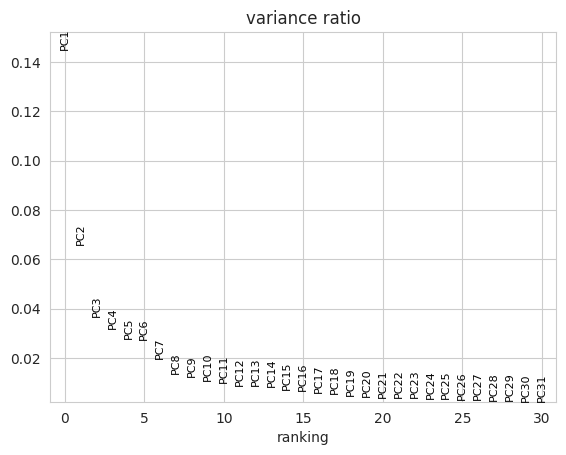

In [310]:
sc.pp.pca(mdata)
sc.pl.pca_variance_ratio(mdata)

In [311]:
sc.pp.neighbors(mdata,n_pcs=10)
sc.tl.umap(mdata)

/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


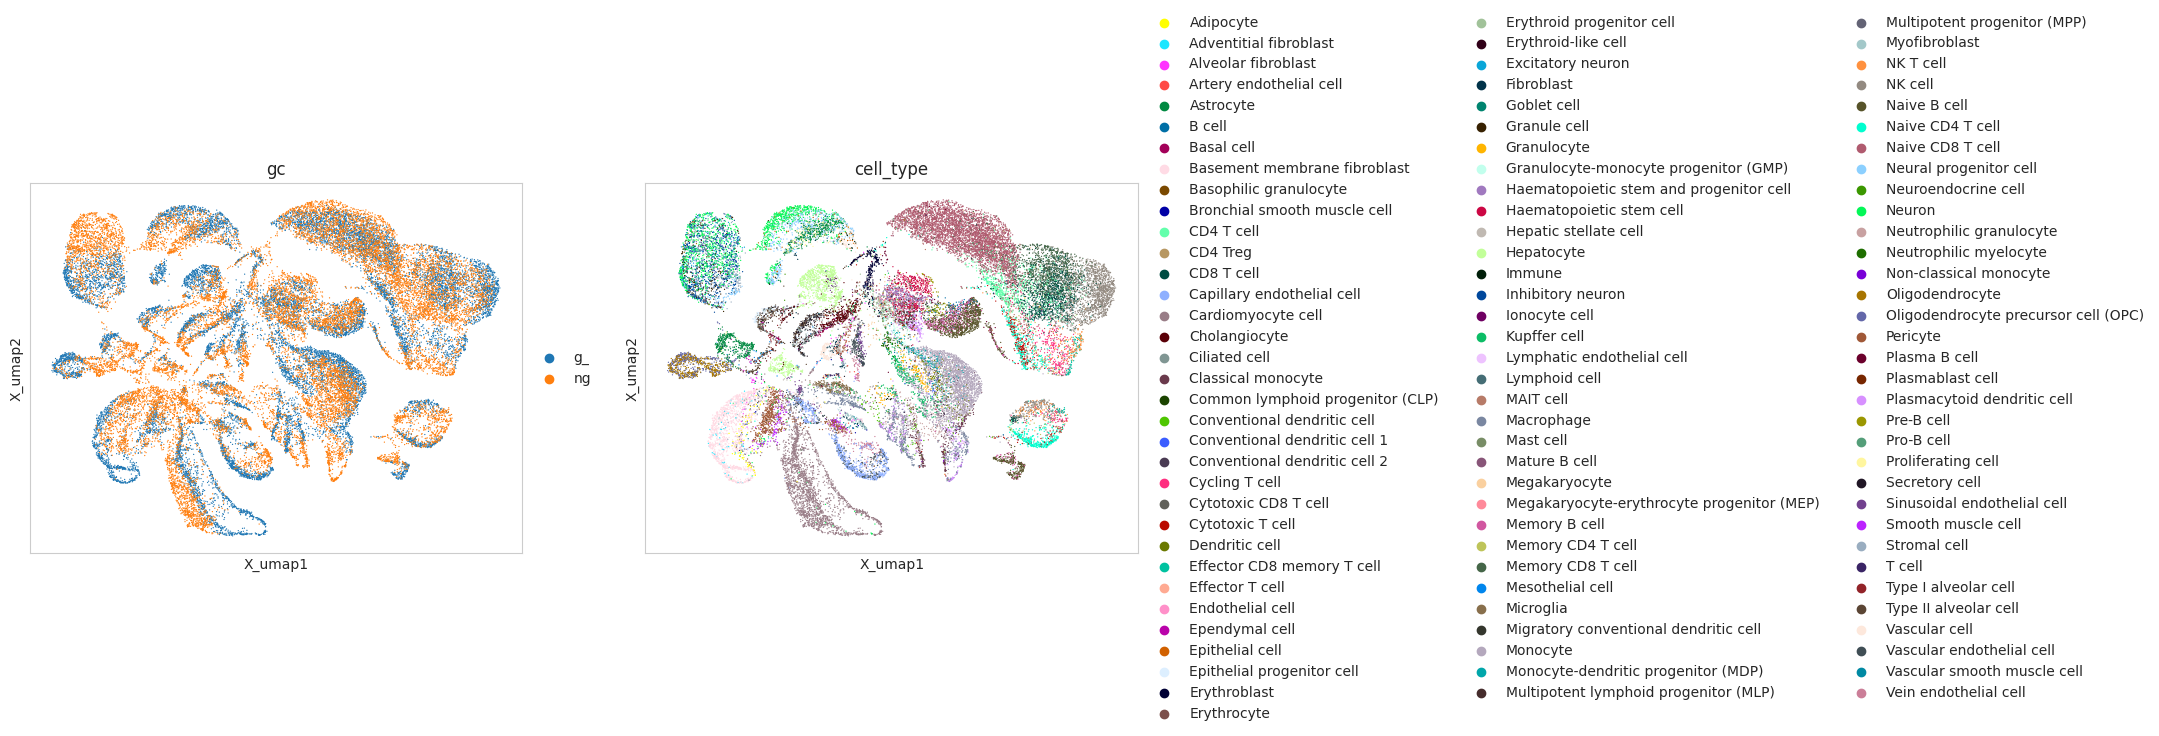

In [312]:
sc.pl.embedding(mdata, basis='X_umap',color=['gc','cell_type'])

In [320]:
mdata.write_h5ad('/nfs/public/cell_gpt_data/dataHub/datasets/datasets/ECA_GO/model_hub/generated_mix_data_test_eca.h5ad')

#### save figures

In [1]:
import scanpy as sc

In [2]:
mdata = sc.read_h5ad('/nfs/public/cell_gpt_data/dataHub/datasets/datasets/ECA_GO/model_hub/generated_mix_data_test_eca.h5ad')

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values

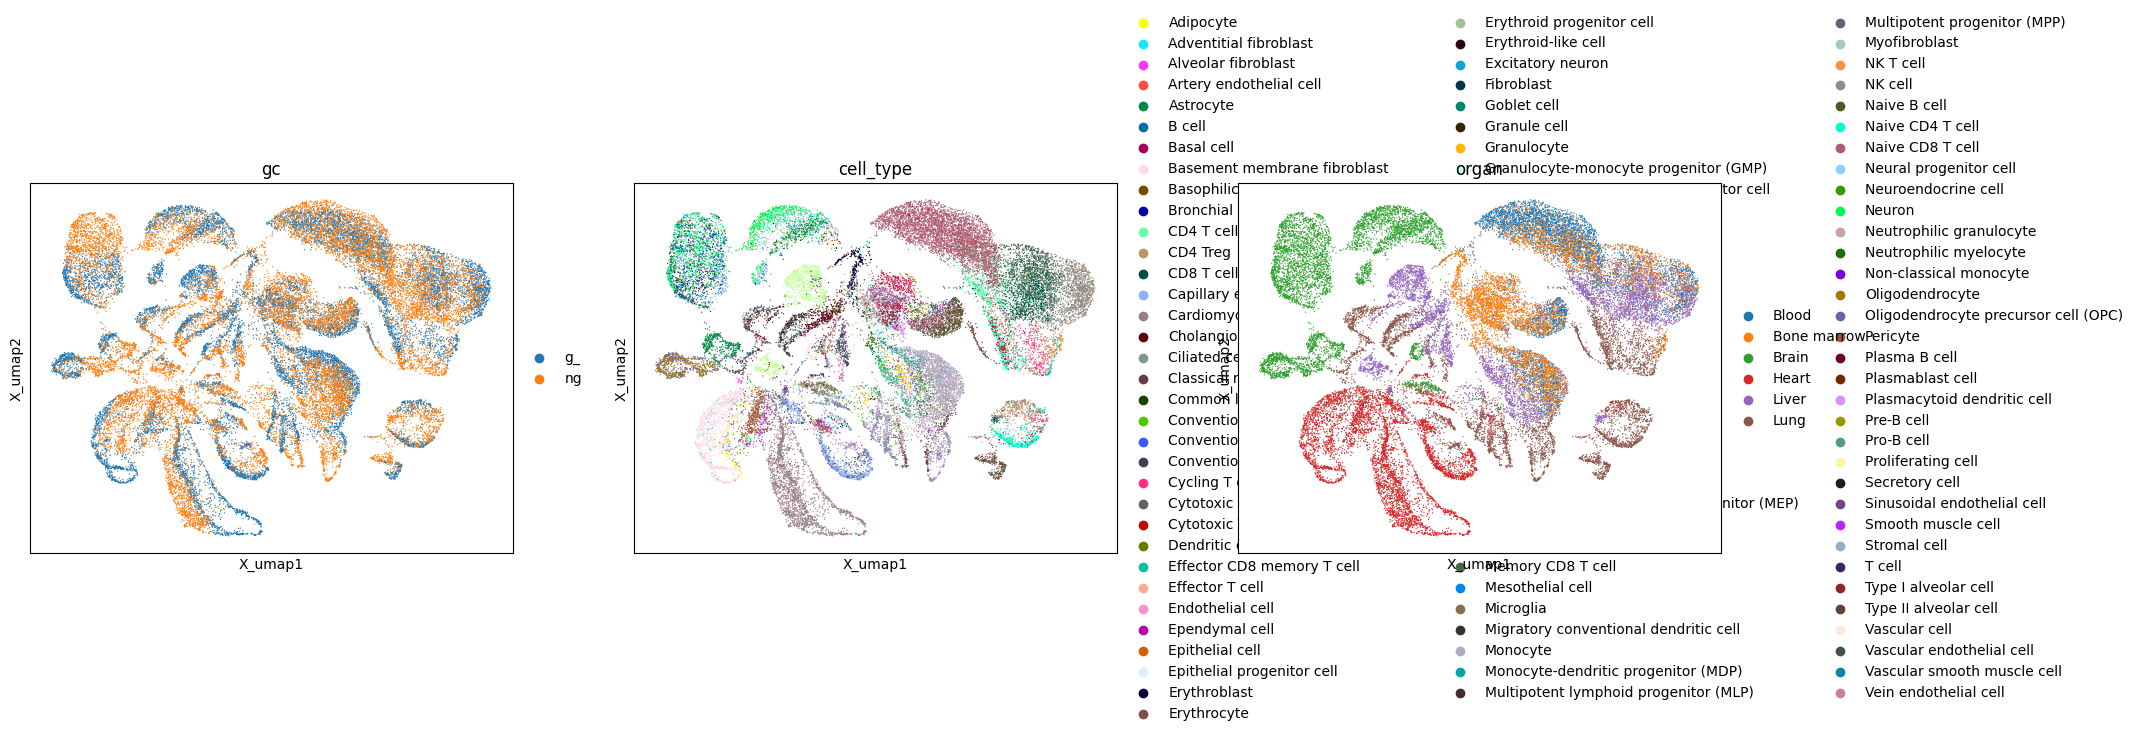

In [19]:
sc.pl.embedding(mdata, basis='X_umap',color=['gc','cell_type','organ'])

In [4]:
mdata.obs['batch'] = "Generated"
mdata.obs['batch'][mdata.obs.gc == "ng"] = "Real"

/tmp/ipykernel_2661713/2050228364.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  mdata.obs['batch'][mdata.obs.gc == "ng"] = "Real"
/tmp/ipykernel_2661713/2050228364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


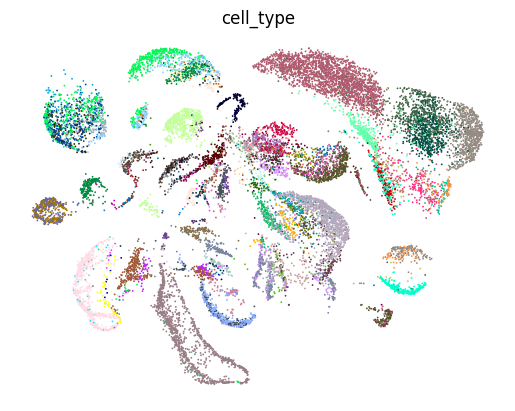

In [11]:
sc.pl.umap(mdata[mdata.obs.batch == "Generated",:], color=['cell_type'],frameon=False, legend_loc=None,save="Generated_cell_type.pdf")

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/anndata/_core/anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


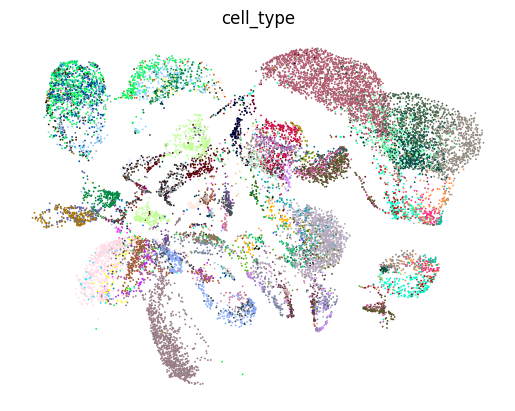

In [12]:
sc.pl.umap(mdata[mdata.obs.batch == "Real",:], color=['cell_type'],frameon=False, legend_loc=None,save="Real_cell_type.pdf")

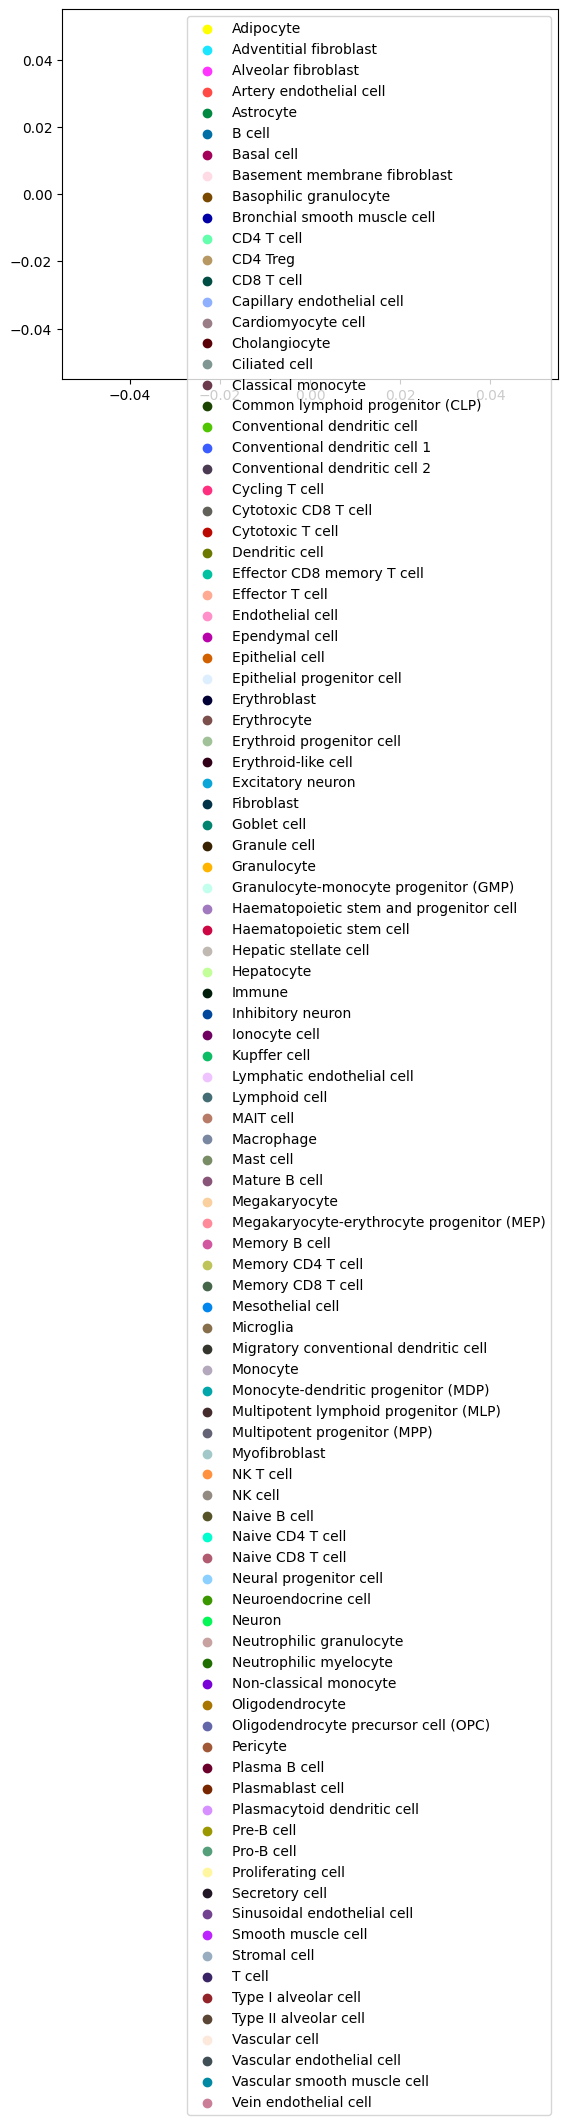

In [21]:
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.scatter([], [])

colors = mdata.uns['cell_type_colors']
labels = mdata.obs.cell_type.cat.categories

# 根据你的颜色和标签创建图例
for color, label in zip(colors, labels):
    plt.scatter([], [], c=color, label=label)

plt.legend()
plt.savefig("figures/Fig4a_cell_type_Legend_only.pdf")  # 导出为PDF
plt.show()

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


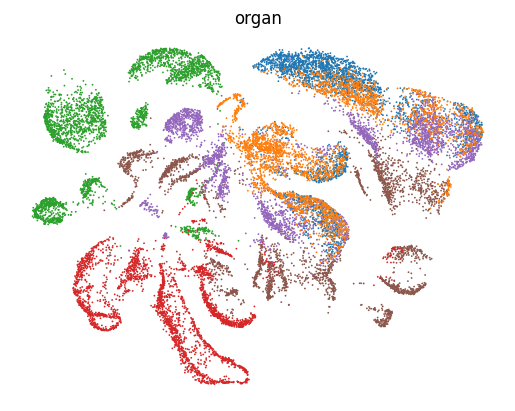

In [22]:
sc.pl.umap(mdata[mdata.obs.batch == "Generated",:], color=['organ'],frameon=False, legend_loc=None,save="Generated_organ.pdf")

/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/data/chenyx/anaconda3/envs/scMulan/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


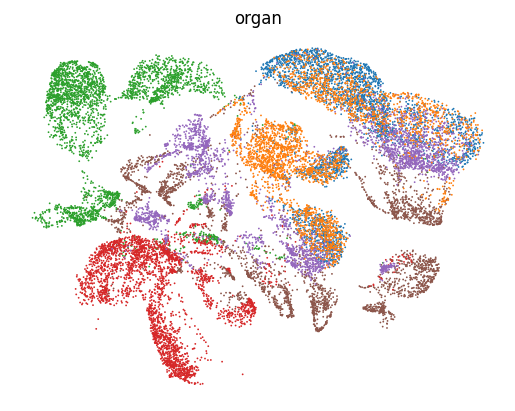

In [23]:
sc.pl.umap(mdata[mdata.obs.batch == "Real",:], color=['organ'],frameon=False, legend_loc=None,save="Real_organ.pdf")

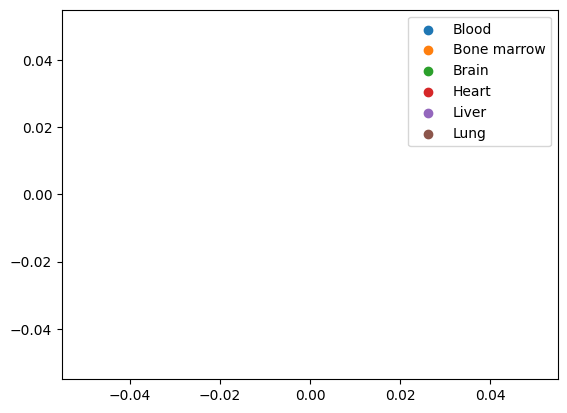

In [24]:
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.scatter([], [])

colors = mdata.uns['organ_colors']
labels = mdata.obs.organ.cat.categories

# 根据你的颜色和标签创建图例
for color, label in zip(colors, labels):
    plt.scatter([], [], c=color, label=label)

plt.legend()
plt.savefig("figures/Fig4a_organ_Legend_only.pdf")  # 导出为PDF
plt.show()

#### Q-Q Plot

In [28]:
def cal_cell_var(adata):
    if isinstance(adata.X,scipy.sparse._csr.csr_matrix):
        return np.array(np.var(adata.X.toarray(),axis=1)).ravel()
    else:
        return np.array(np.var(adata.X,axis=1)).ravel()
    
def cal_peak_var(adata):
    if isinstance(adata.X,scipy.sparse._csr.csr_matrix):
        return np.array(np.var(adata.X.toarray(),axis=0)).ravel()
    else:
        return np.array(np.var(adata.X,axis=0)).ravel()
    
def cal_peak_nozero(adata):# sparsity
    X=adata.X.copy()
    X[X>0]=1
    sparsity=np.sum(X,axis=0)
    return np.array(sparsity).ravel()

# library size
def cal_lib(adata):
    return np.array(np.sum(adata.X,axis=1)).ravel()

def cal_pm(adata): # peak mean
    return (np.array(np.sum(adata.X,axis=0))/adata.X.shape[0]).ravel()

def cal_pl(adata):# peak length
    start=np.array([int(i.split('_')[1]) for i in adata.var.index])
    end=np.array([int(i.split('_')[2]) for i in adata.var.index])
    return (end-start).ravel()

def cal_nozero(adata):# sparsity
    X=adata.X.copy()
    X[X>0]=1
    sparsity=np.sum(X,axis=1)
    return np.array(sparsity).ravel()

def cal_peak_count(adata):
    return np.array(np.sum(adata.X,axis=0)).ravel()

def cal_spa(adata):# sparsity
    X=adata.X.copy()
    X[X>0]=1
    sparsity=np.sum(X,axis=1)/X.shape[1]
    return np.array(sparsity).ravel()

def cal_peak_spa(adata):# sparsity
    X=adata.X.copy()
    X[X>0]=1
    sparsity=np.sum(X,axis=0)/X.shape[0]
    return np.array(sparsity).ravel()

def cal_quantile_t(my_array,quantile=1000):
    sorted_array=np.sort(my_array)
    interval=len(my_array)/quantile
    return np.array([sorted_array[int(i*interval)] for i in range(quantile)])

In [31]:
adata_ori = mdata[mdata.obs.batch=="Real"].copy()
adata =mdata[mdata.obs.batch=="Generated"].copy()

In [33]:
import seaborn as sns

In [36]:
sns.set_style("whitegrid")
log_=1
range_=100
label_size=15

pm=cal_pm(adata)
lib=cal_lib(adata)
spa=1-cal_spa(adata)
peak_spa=1-cal_peak_spa(adata)

pm_ori=cal_pm(adata_ori)
lib_ori=cal_lib(adata_ori)
spa_ori=1-cal_spa(adata_ori)
peak_spa_ori=1-cal_peak_spa(adata_ori)

spa_re = cal_spa(adata)
spa_re_ori = cal_spa(adata_ori)

finish1
finish2
finish3


/tmp/ipykernel_2661713/3431279214.py:98: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles=legend.legendHandles,


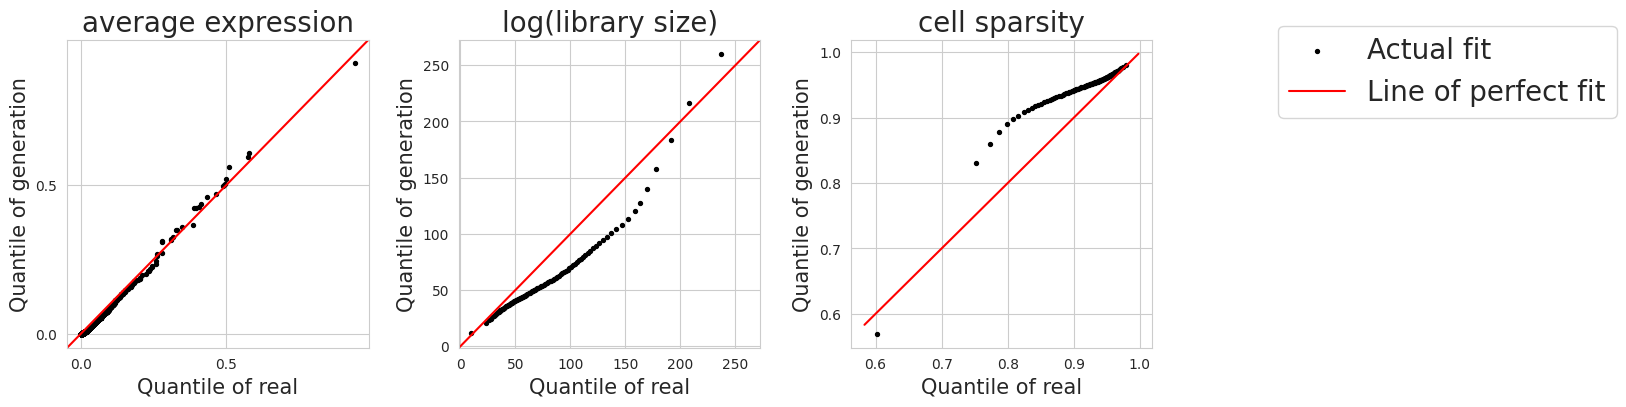

In [37]:
fig=plt.figure(figsize=(14,4))
ax1=plt.subplot(131)
df_pct = pd.DataFrame()
df_pct['original'] = cal_quantile_t(pm_ori,2000)
df_pct['simCAS'] = cal_quantile_t(pm,2000)
plt.scatter(x='original', y='simCAS', data=df_pct, label='Actual fit',s=8,c='black');
plt.xlabel('Quantile of real',fontsize=label_size)
plt.ylabel('Quantile of generation',fontsize=label_size)
lim1,lim2=min(ax1.get_ylim()[0],ax1.get_xlim()[0]),max(ax1.get_ylim()[1],ax1.get_xlim()[1])
ax1.set_xlim(lim1,lim2)
ax1.set_ylim(lim1,lim2)
ax1.set_xticks(np.arange(0,lim2, 0.5))
ax1.set_yticks(np.arange(0,lim2, 0.5))

df_pct = pd.DataFrame()
df_pct['original'] = [ax1.get_xlim()[0],ax1.get_xlim()[1]]
sns.lineplot(x='original', y='original', data=df_pct, color='r', label='Line of perfect fit')

legend=ax1.get_legend()
legend.remove()
# plt.legend(test)
plt.title("average expression",fontsize=20)
print('finish1')

### library size

ax2=plt.subplot(132)
df_pct = pd.DataFrame()
df_pct['original'] = cal_quantile_t(lib_ori,100)
df_pct['simCAS'] = cal_quantile_t(lib,100)

plt.scatter(x='original', y='simCAS', data=df_pct, label='Actual fit',s=8,c='black');
plt.xlabel('Quantile of real',fontsize=label_size)
plt.ylabel('Quantile of generation',fontsize=label_size)
lim1,lim2=min(ax2.get_ylim()[0],ax2.get_xlim()[0]),max(ax2.get_ylim()[1],ax2.get_xlim()[1])
ax2.set_xlim(lim1,lim2)
ax2.set_ylim(lim1,lim2)

df_pct = pd.DataFrame()
df_pct['original'] = [ax2.get_xlim()[0],ax2.get_xlim()[1]]
sns.lineplot(x='original', y='original', data=df_pct, color='r', label='Line of perfect fit')
legend=ax2.get_legend()
legend.remove()
plt.title("log(library size)",fontsize=20)
print('finish2')

ax3=plt.subplot(133)
df_pct = pd.DataFrame()
df_pct['original'] = cal_quantile_t(spa_ori,100)
df_pct['simCAS'] = cal_quantile_t(spa,100)

plt.scatter(x='original', y='simCAS', data=df_pct, label='Actual fit',s=8,c='black');
plt.xlabel('Quantile of real',fontsize=label_size)
plt.ylabel('Quantile of generation',fontsize=label_size)
df_pct = pd.DataFrame()
df_pct['original'] = [ax3.get_xlim()[0],ax3.get_xlim()[1]]
sns.lineplot(x='original', y='original', data=df_pct, color='r', label='Line of perfect fit')

legend=ax3.get_legend()
legend.remove()
plt.title("cell sparsity",fontsize=20)
print('finish3')



legend=fig.legend(
            handles=legend.legendHandles,
           loc = 2, 
           bbox_to_anchor = (0.98,0.95),
            fontsize=20,
          )
prefix_ = 'scMulan'

save_dir = 'figures/'
plt.subplots_adjust(wspace=0.3,hspace=0.3)
fig.savefig(save_dir+'{0}_QQplot_test{1}.pdf'.format(prefix_,'C2'),facecolor='white',bbox_inches='tight')